In [6]:
# !pip install peft

Defaulting to user installation because normal site-packages is not writeable
  Using cached peft-0.10.0-py3-none-any.whl (199 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 KB 7.9 MB/s eta 0:00:0000:01


In [15]:
# !pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/d6/07/061f97211f942101070a46fecd813a6b1bd83590ed7b07c473cabd707fe7/matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/67/0f/6e5b4879594cd1cbb6a2754d9230937be444f404cf07c360c07a10b36aac/contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/67/09/e09ee013d9d6f2f006147e5fc2b4d807eb2931f4f890c2d4f711e10391d7/fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms
# https://anirbansen2709.medium.com/finetuning-llms-using-lora-77fb02cbbc48
# https://github.com/microsoft/LoRA/tree/main/examples/NLG
# https://github.com/huggingface/peft


In [1]:
import sys
import gc
import torch
sys.path.append('/home/blatova/lca-solvers/')
from torch.utils.data import DataLoader
from transformers import AdamW
import math
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

In [2]:
import random

from transformers import AutoTokenizer, AutoModelForCausalLM

from data_filters.repo_snapshot_filter_stack import SnapshotFilterStack
from data_classes.datapoint_composed import DatapointComposed
from data_loading.raw_train_dataset_loading import DataLoaderTrainRaw
from data_loading.composer_train_dataset_loading import DataLoaderTrainComposed
from context_composers.context_composer_path_distance import ContextComposerPathDistance
from data_classes.datapoint_composed import DatapointComposed
from datasets import load_dataset
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# NUM_FILES=250

# class ContextComposerTestLength(ContextComposerBase):
#     def __init__(self):
#         super().__init__()
#         pass

#     def compose_context(self, datapoint: DatapointBase, num_files=2) -> str:
#         relevant_context = datapoint.get_relevant_context()
#         non_relevant_context = datapoint.get_non_relevant_context()
#         context =""
#         for i in range(num_files):
#             filename = random.choice(list(relevant_context))
#             content= relevant_context[filename]
#             context=context+f"# {filename}\n\n{content}\n\n"
#         return context

In [3]:
!nvidia-smi

Thu Apr 18 21:18:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   31C    P8              12W / 450W |      6MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!kill -9 1694536

/bin/bash: line 1: kill: (1694536) - No such process


In [4]:
# loader = DataLoader(cache_dir="/home/blatova/cache_dir")
loader = DataLoaderTrainComposed(
        hf_path='JetBrains-Research/context-py-train',
        hf_config=None,
        cache_dir='/mnt/data2/shared-data/lca/hf_cache2/',
    )
composer = ContextComposerPathDistance()
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True, torch_dtype=torch.bfloat16).to("cuda:3")

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# ds = load_dataset('JetBrains-Research/context-py-train', 'path_distance_relevant', cache_dir = '/mnt/data2/shared-data/lca/hf_cache2/')
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

model_lora = get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()
criterion = CrossEntropyLoss()

trainable params: 1,572,864 || all params: 1,348,044,800 || trainable%: 0.11667742793117855


In [6]:
#6000 tokens => OOM
ACCUM_STEPS_NUM = 64
CONTEXT_MAX_LEN_CHARS = 16000
CONTEXT_MAX_LEN_TOKENS = 4000

In [7]:
optimizer = AdamW(model_lora.parameters(), lr=5e-5)

/home/blatova/lca-solvers/venv/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
def compose_input_sequence(dp: DatapointComposed, max_len: int, context_ratio: float = 0.75) -> str:
    if not -1e8 < context_ratio < 1. + 1e8:
        raise ValueError('context_ratio must be between 0 and 1')
    context = dp.context
    completion = dp.completion

    length_context = int(max_len * context_ratio) + 1
    length_completion = int(max_len * (1 - context_ratio)) + 1

    compl_trim_idx = completion.find('\n', length_completion)
    context_trim_idx = context.rfind('\n', 0, -length_context)

    if compl_trim_idx > 0:
        completion_trimmed = completion[:compl_trim_idx]
    else:
        completion_trimmed = completion

    if context_trim_idx > 0:
        context_trimmed = context[1+context_trim_idx:]
    else:
        context_trimmed = context

    return context_trimmed + '\n---------CONTEXT SEPARATOR---------\n' + completion_trimmed

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def live_plot(data, figsize=(10,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data, marker='o')
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

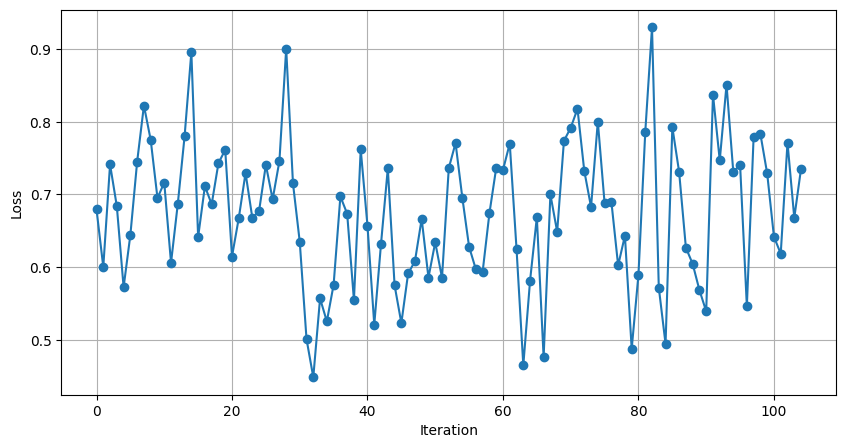

Plotted: 6720 steps


KeyboardInterrupt: 

In [10]:
torch.cuda.empty_cache()
total_loss = 0
total_tokens = 0
train_losses = []
curr_train_loss = []
for idx, hf_dp in enumerate(loader.get_datapoint_iterator()):
    # torch.cuda.empty_cache()
    # if idx > 20:
    #     break
    
    dp = DatapointComposed.from_hf_datapoint(hf_dp.dp)
    context = compose_input_sequence(dp, max_len = CONTEXT_MAX_LEN_CHARS, context_ratio=0.95)
    # context = context[-15000:]
    inputs = tokenizer(context, return_tensors="pt").to(model.device)
    inputs['input_ids'] =inputs['input_ids'][:,-CONTEXT_MAX_LEN_TOKENS:]
    inputs['attention_mask'] =inputs['attention_mask'][:,-CONTEXT_MAX_LEN_TOKENS:]
    outputs = model_lora.forward(**inputs)
    # print(outputs['logits'].shape)
    # print(inputs['input_ids'].shape)
    # print(inputs['attention_mask'].shape)
    logits_size = outputs['logits'].size(-1)
    # for 0 output logit we have corresponding 1st input
    loss = criterion(outputs['logits'].view(-1, outputs['logits'].size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:]) 
    loss.backward()
    if (idx+1) % ACCUM_STEPS_NUM ==0:
        train_losses.append(sum(curr_train_loss)/len(curr_train_loss))
        curr_train_loss = []
        for param in model_lora.parameters():
            if param.requires_grad:
                if param.grad is not None:
                    param.grad /= ACCUM_STEPS_NUM
        
        optimizer.step()
        optimizer.zero_grad()

    if (idx+1) % (ACCUM_STEPS_NUM*5) ==0:
        live_plot(train_losses)
        print(f"Plotted: {(idx+1)} steps")
        
    
    curr_train_loss.append(loss.item())
    total_loss += loss.item() * (inputs['input_ids'].size(0)-1)  # Accumulate scaled loss
    total_tokens += (inputs['input_ids'].numel()-1)  # Count tokens processed
    # TODO validation

avg_loss = total_loss / total_tokens
perplexity = math.exp(avg_loss)  # Calculate perplexity as exp of the average loss




    

In [15]:
print(len(train_losses))

12


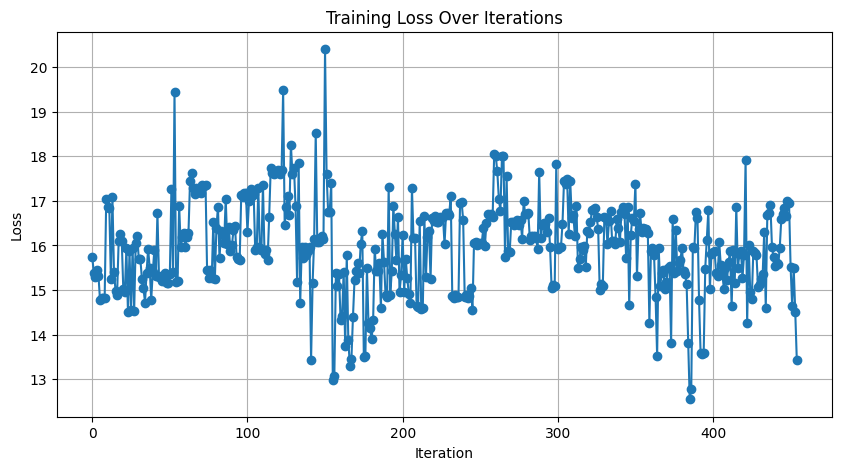

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()